In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
import tensorflow.keras.layers as ly
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
train_b = True

In [ ]:
def RMSE(y_test,y_pred):
    y_test = list(y_test); y_test = [float(e) for e in y_test]
    y_pred = list(y_pred); y_pred = [float(e) for e in y_pred]
    n = len(y_test)
    rmse_list = [float(y_test[i]-y_pred[i])*float(y_test[i]-y_pred[i]) for i in range(n)]
    return np.sqrt(sum(rmse_list)/float(n))
def RMSE_list(y_test,y_pred):
    y_test = list(y_test); 
    y_test = [list(ln) for ln in y_test]
    y_pred = list(y_pred); 
    y_pred = [list(ln) for ln in y_pred]
    n = len(y_test); m = len(y_test[0])
    rmse_list = [np.square(float(y_test[i][j]-y_pred[i][j])) for i in range(n) for j in range(m)]
    return np.sqrt(sum(rmse_list)/float(n))

#Load and Reshape Data

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data"
hist_window=18;forecast_window=18
#hist_window=int(12*60/5)

In [ ]:
data = []
#for y in range(2017,2023):
year_list = [2017,2018,2019,2020,2021]
for y in year_list:
  df = pd.read_csv(f"{DATA_DIR}/Total_Data_{y}_5m.csv")
  data.append(df)
data = pd.concat(data)
time_range = str(year_list[0])+"-"+str(year_list[-2])


future_var = ['Global Horizontal UV Irradiance (280-400nm)','HourlyDryBulbTemperature']
for c in future_var:
  data[c+" Future"] = data[c].shift(-forecast_window).backfill()

used_var = ['N.Y.C.','Global Horizontal UV Irradiance (280-400nm)','HourlyDryBulbTemperature','Global Horizontal UV Irradiance (280-400nm) Future','HourlyDryBulbTemperature Future']
data = data[used_var].backfill();
data = data.dropna(how='any')

for c in used_var:
  #print(data[c].head(15));
  print(c,len(data[c].index),data[c].mean(),data[c].std())

print(data.head(5).to_string())
n = len(data.index)
t = int(365*24*(60/5))
num_var = len(used_var)

N.Y.C. 525870 5807.584429113562 1232.9113146306042
Global Horizontal UV Irradiance (280-400nm) 525870 9.192380245307776 14.740024519550754
HourlyDryBulbTemperature 525870 55.41655574559083 16.785011018559658
Global Horizontal UV Irradiance (280-400nm) Future 525870 9.19238024530778 14.740024519550754
HourlyDryBulbTemperature Future 525870 55.416710066533156 16.784927700967568
   N.Y.C.  Global Horizontal UV Irradiance (280-400nm)  HourlyDryBulbTemperature  Global Horizontal UV Irradiance (280-400nm) Future  HourlyDryBulbTemperature Future
0  5116.9                                          0.0                      44.0                                                 0.0                        44.588235
1  5102.1                                          0.0                      44.0                                                 0.0                        44.686275
2  5074.9                                          0.0                      44.0                                           

In [ ]:
data

,N.Y.C.,Global Horizontal UV Irradiance (280-400nm),HourlyDryBulbTemperature,Global Horizontal UV Irradiance (280-400nm) Future,HourlyDryBulbTemperature Future
0,5116.9000,0.0,44.0000,0.0,44.588235
1,5102.1000,0.0,44.0000,0.0,44.686275
2,5074.9000,0.0,44.0000,0.0,44.784314
3,5089.6000,0.0,44.0000,0.0,44.882353
4,5061.3000,0.0,44.0000,0.0,44.980392
...,...,...,...,...,...
105097,4999.0645,0.0,48.6875,0.0,49.000000
105098,4970.3545,0.0,48.3750,0.0,49.000000
105099,4971.9966,0.0,48.0625,0.0,49.000000
105100,4916.0596,0.0,48.0000,0.0,49.000000


In [ ]:
m = 5574.113154123897;std = 1157.6820234795014
m_s = 9.305353909378894 ;std_s = 14.708926535057076
m_t = 56.030910041113;std_t = 16.507268780702415


m_list = [m,m_s,m_t,m_s,m_t]
std_list = [std,std_s,std_t,std_s,std_t]

def untransform_dataset_old(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==3:
    ns,nv,tw = s #ns = number of samples, nv = number of variables, tw = time window
    dataset=dataset.reshape(nv,ns*tw)
    dataset = np.array([(dataset[i]*stdi[i])+mi[i] for i in range(s[1])])
    dataset=dataset.reshape(s[0],s[1],s[2])
  else: 
    dataset=(dataset*stdi[0])+mi[0]
  return dataset

def create_dataset(dataset, hist_window=18,forecast_window=18):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(len(dataset)-hist_window-forecast_window):
    a = dataset[i:(i+hist_window)].reshape(-1); dataX.append(a)
    dataY.append(dataset[i + hist_window:  i + hist_window+forecast_window])
  return np.array(dataX), np.array(dataY)
def create_dataset_mult(dataset, hist_window=18,forecast_window=18,num_var=3):
  #Lookback of 18 includes 90 minutes of previous data
  dataX, dataY = [], []
  for i in range(dataset.shape[0]-hist_window-forecast_window):
    a = dataset[i:(i+hist_window)].T
    dataX.append(a)
    
    e = dataset[i + hist_window:  i + hist_window+forecast_window, 0]
    dataY.append(e)
  return np.array(dataX), np.array(dataY)

def transform_dataset(dataset,mi=m_list,stdi=std_list):
  s = dataset.shape
  if len(s)==2:
    #ns,nv,tw = s #ns = number of samples, nv = number of variables, tw = time window
    ns,nv = s
    dataset=dataset.T 
    dataset = np.array([(dataset[i]-mi[i])/stdi[i] for i in range(s[1])])
    dataset=dataset.T 
  else:
    dataset=(dataset-mi[0])/stdi[0] 
  return dataset
def untransform_dataset(dataset,mi=m_list,stdi=std_list):
  dataset=(dataset*stdi[0])+mi[0]
  return dataset  
dataset = data[used_var].values
dataset_xfr = transform_dataset(dataset)

x,y = create_dataset_mult(dataset_xfr,hist_window,forecast_window,num_var)
train,label_t = x[0:n-t],y[0:n-t]
valid,label_v = x[n-t:], y[n-t:]

In [ ]:
# reshape input to be [samples, time steps, features]
#print(train.shape)
#train = np.reshape(train, (train.shape[0], num_var, train.shape[1]))
#valid = np.reshape(valid, (valid.shape[0], num_var, valid.shape[1]))

#Build Model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               47600     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 18)                1818      
                                                                 
Total params: 49,418
Trainable params: 49,418
Non-trainable params: 0
_________________________________________________________________


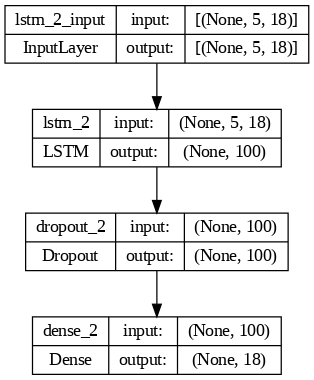

In [ ]:
import datetime
MODEL_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Cross Validation"
def create_LSTM_model(LSTM_i = 4, dropout=0.3,
                      learning_rate=0.00005,var_num = 2,
                      hist_window=18,forecast_window=18):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
    """
    model = Sequential()
    model.add(LSTM(LSTM_i, input_shape=(var_num,hist_window)))
    model.add(Dropout(.1))
    model.add(Dense(forecast_window))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_LSTM_model(LSTM_i=100, var_num=num_var)
model.summary()
plot_model(model, show_shapes=True, dpi=90)

In [ ]:
#Fit Model
model_name = f"test_model_slope_with_solar_weather_future_100_{time_range}.h5"
print(datetime.datetime.now())
if train_b:
  model.fit(train, label_t, epochs=5, batch_size=16, verbose=2)
  model.save(f"{MODEL_DIR}/{model_name}",save_format='h5')
else: 
  model.load_weights(f"{MODEL_DIR}/{model_name}") 

2023-02-26 22:17:44.680101
Epoch 1/5
26297/26297 - 122s - loss: 0.0147 - 122s/epoch - 5ms/step
Epoch 2/5
26297/26297 - 119s - loss: 0.0070 - 119s/epoch - 5ms/step
Epoch 3/5
26297/26297 - 117s - loss: 0.0062 - 117s/epoch - 4ms/step
Epoch 4/5
26297/26297 - 117s - loss: 0.0058 - 117s/epoch - 4ms/step
Epoch 5/5
26297/26297 - 117s - loss: 0.0055 - 117s/epoch - 4ms/step


3284/3284 [==============================] - 9s 3ms/step
Test Score: 288.09 RMSE
Test Score: 102.82 RMSE


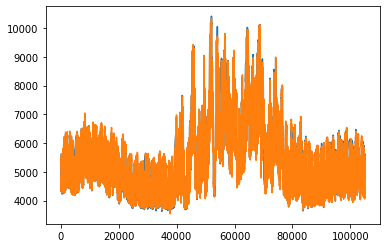

In [ ]:
# make predictions
valid,label_v = x[n-t:], y[n-t:]
label_p   = model.predict(valid)

## invert predictions
label_p = untransform_dataset(label_p)
label_v = untransform_dataset(label_v)

# calculate root mean squared error
print('Test Score: %.2f RMSE' % (RMSE_list(label_v, label_p)))

for i,ln in enumerate(label_p):
  if i==0: 
    label_p_plot=list(label_p[0])
    label_v_plot=list(label_v[0])
  else:
    label_p_plot=label_p_plot+ [label_p[i][-1]]
    label_v_plot=label_v_plot+ [label_v[i][-1]]

print('Test Score: %.2f RMSE' % (RMSE(label_v_plot, label_p_plot)))

plt.plot(label_v_plot);
plt.plot(label_p_plot)
plt.show()